# preprocess of recurrence

In [1]:
# 基本的なライブラリ
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# パイプライン
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from pipelines import *

# データ分割
from sklearn.model_selection import train_test_split

# スケーリング
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 次元削減
from sklearn.decomposition import PCA

import config
import functions

SEED = config.SEED
functions.fix_seed(SEED)
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
STRATIFY_NAME = "RFS_STATUS"
%matplotlib inline

/home/breast-cancer-analytics/notebooks/functions.py:196: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/home/breast-cancer-analytics/notebooks/functions.py:198: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")

## カラムの順序変更（読みやすさのため）

In [3]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    _df = df.copy()
    df_tmp = _df.filter(regex=regex)
    # 元のdfから落とす
    _df.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(_df, df_tmp, right_index=True, left_index=True)


def sort_columns_by_knowledge(df):
    _df = df.copy()
    # 癌の種類
    _df = align_columns(_df, "^CANCER_")
    # 重要そう（直感）な特徴量
    _df = align_columns(_df, "^ER_|^HER2_|^TUMOR_")
    # 治療の種類
    _df = align_columns(_df, ".*THERAPY$|^BREAST_SURGERY")
    # target系の種類（OS, RFS, VITAL）
    _df = align_columns(_df, "^OS_.*|^RFS_.*|^VITAL_.*")
    return _df


df_clinical = sort_columns_by_knowledge(df_clinical)

In [4]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]

df_MB.set_index("PATIENT_ID", inplace=True)
df_MTST.set_index("PATIENT_ID", inplace=True)

display(df_MB.shape, df_MTST.shape)
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_clinical.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MTST.pkl")
del df_patient, df_sample, df_clinical, df_MB, df_MTST

(1985, 35)

(524, 35)

## 臨床・遺伝子データの読み込み

In [5]:
# 臨床データ
df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")

# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()

# 前処理
- 目的変数生成
- 特徴量生成
- 特徴名のrename 
- 欠損値の削除


## 目的変数の生成

目的変数は再発年数（連続値）である。しかし、RFS_STATUSが0の患者は非再発であり、RFS_MONTHSは手術〜最終フォローアップの期間を示している。
そこで、非再発患者のRFS_MONTHSは0にする必要がある。

## 特徴量生成
予測の**層別化に必要な特徴を生成**する。

**層別化に必要な特徴**
- CLAUDIN_SUBTYPE
- NPI
- TUMOR_SIZE
- LYMPH_NODES_EXAMINED_POSITIVE

数値データは層別化のためにカテゴリ化を行う。
各カテゴリ化の根拠は以下の通り。
- NPI：( ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index )
- TUMOR_SIZE：乳癌のステージの定義( https://oshiete-gan.jp/breast/diagnosis/stages/detail.html )
- LYMPH_NODES_EXAMINED_POSITIVE：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

## 特徴量名のrename
重複した特徴量は別のものとして扱う


## 欠損値の削除
- 欠損値が多い→特徴量の削除  
- 欠損値が少ない→サンプルの削除

In [6]:
def generate_target():
    # RFS_STATUS, RFS_MONTHSのnullデータについては患者データを削除する
    df_MB.dropna(subset=["RFS_STATUS", "RFS_MONTHS"], inplace=True)
    # 予測ラベルを扱いやすい形に変更
    # scikit-survivalの予測モデルでは、RFS_STATUSがboolである必要がある（イベント発生がTrue, 打ち切りがFalse）
    df_MB["RFS_STATUS"] = df_MB["RFS_STATUS"].replace(
        {"1:Recurred": True, "0:Not Recurred": False}
    )


def generate_features():
    df_MB["NPI_CAT"] = pd.cut(
        df_MB.NPI,
        [0, 2.0, 2.4, 3.4, 5.4, np.inf],
        labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
    )
    df_MB["TUMOR_CAT"] = pd.cut(
        df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
    )
    df_MB["LYMPH_CAT"] = pd.cut(
        df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
        [-np.inf, 0, 3, np.inf],
        labels=["0", "1~3", "4~inf"],
    )


def rename_duplicatged_columns(df):
    _df = df.copy()
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename前）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )

    cols = pd.Series(_df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "_" + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    _df.columns = cols
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename後）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )
    return _df


def drop_null4cols(df):
    _df = df.copy()
    print(
        "欠損値が多い特徴個数：",
        (_df.isnull().sum() > _df.shape[0] // 10).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 多数の欠損値を持つ特徴
    many_null_features = features[_df.isnull().sum() > _df.shape[0] // 10].index
    # 多数の欠損値を持つ特徴の削除
    _df.drop(many_null_features, axis=1, inplace=True)
    return _df


def drop_null4raws(df):
    _df = df.copy()
    print(
        "欠損値が少ない特徴個数：",
        ((_df.isnull().sum() < +_df.shape[0] // 10) & (_df.isnull().sum() > 0)).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 少数の欠損値を持つ特徴
    few_null_features = features[
        (_df.isnull().sum() <= _df.shape[0] // 10) & (_df.isnull().sum() > 0)
    ]
    # 少数の欠損値の遺伝子発現を持つ患者ID
    list_patient_id_contains_null_expressions = list()
    for name in few_null_features.index:
        for patient_id in _df[_df[name].isnull()].index:
            list_patient_id_contains_null_expressions.append(patient_id)

    # 少数の欠損値の遺伝子発現を持つ患者の削除
    _df.drop(list_patient_id_contains_null_expressions, inplace=True)
    return _df

重複特徴名数（rename前）： 0
重複特徴名数（rename後）： 0
欠損値が多い特徴個数： 0
欠損値が少ない特徴個数： 11


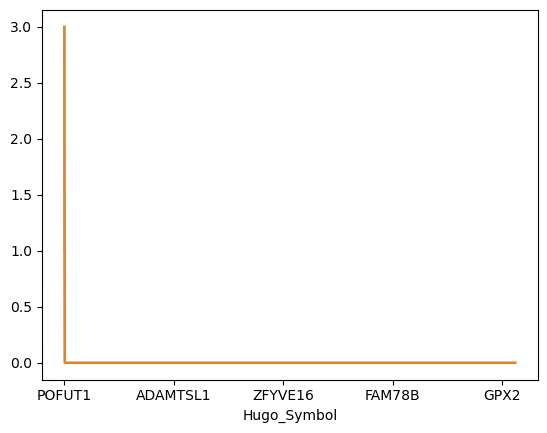

In [7]:
# 臨床データ
generate_target()
generate_features()
# 遺伝子データ
df_gene_expressions = df_mrna_agilent_microarray.copy()
df_gene_expressions = rename_duplicatged_columns(df_gene_expressions)
df_gene_expressions = drop_null4cols(df_gene_expressions)
df_gene_expressions = drop_null4raws(df_gene_expressions)
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_gene_expressions.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_gene_expressions.pkl"
)

# 臨床データと遺伝子データの結合

患者の必要な特徴を含む臨床データと遺伝子データを結合する。

## 臨床データ

**必要な特徴**

目的変数
- RFS_OVER_nMONTHS  

層別化対象候補
- CLAUDIN_SUBTYPE
- NPI_CAT
- TUMOR_CAT
- LYMPH_CAT

## 遺伝子データ
遺伝子データは全ての特徴量を結合する。

In [8]:
left_features = [
    "RFS_MONTHS",
    "RFS_STATUS",
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
]

df_merged = pd.merge(
    df_MB[left_features],
    df_gene_expressions,
    left_index=True,
    right_index=True,
)
# 半角スペースやバックスラッシュはpklファイル保存時に邪魔になるので置き換え
df_merged["THREEGENE"] = df_merged.THREEGENE.str.replace("/", "_")
df_merged["THREEGENE"] = df_merged.THREEGENE.str.replace(" ", "_")

# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_merged.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_merged4numeric.pkl"
)
df_recurrenced = df_merged.copy()
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_merged.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

## データ分割

訓練データ、検証データ、テストデータに層化分割する   
比率は(train, val, test)=(0.81, 0.09, 0.1)  
CVは行わずに通常のholdoutで検証は行う（特徴選択を毎度実施するのが厄介なため）


In [9]:
# データ分割のためのクラス
# pythonのミュータブルオブジェクトの外部操作を防ぐためにcopy()の使用&private化
class SplitDataFrame:
    def __init__(self, df, train_size: float = 0.9):
        self.__df = df.copy()
        self.__train_size = train_size

        self.__df_train = None
        self.__df_val = None
        self.__df_train_val = None
        self.__df_test = None

        self.__X_train = None
        self.__y_train = None
        self.__X_val = None
        self.__y_val = None
        self.__X_train_val = None
        self.__y_train_val = None
        self.__X_test = None
        self.__y_test = None

    def split_train_val_test(self):
        # train & test
        self.__df_train_val, self.__df_test = train_test_split(
            self.__df,
            train_size=self.__train_size,
            stratify=self.__df[STRATIFY_NAME],
            random_state=SEED,
        )
        # train & val
        self.__df_train, self.__df_val = train_test_split(
            self.__df_train_val,
            train_size=self.__train_size,
            stratify=self.__df_train_val[STRATIFY_NAME],
            random_state=SEED,
        )

    def split_X_y(self):
        self.__X_train, self.__y_train = (
            self.__df_train.drop(TARGET_NAME, axis=1),
            self.__df_train[TARGET_NAME],
        )
        self.__X_val, self.__y_val = (
            self.__df_val.drop(TARGET_NAME, axis=1),
            self.__df_val[TARGET_NAME],
        )
        self.__X_train_val, self.__y_train_val = (
            self.__df_train_val.drop(TARGET_NAME, axis=1),
            self.__df_train_val[TARGET_NAME],
        )
        self.__X_test, self.__y_test = (
            self.__df_test.drop(TARGET_NAME, axis=1),
            self.__df_test[TARGET_NAME],
        )

    def get_train_val(self):
        return self.__train_val.copy()

    def get_train(self):
        return self.__train.copy()

    def get_val(self):
        return self.__val.copy()

    def get_test(self):
        return self.__test.copy()

    def get_train_val_Xy(self):
        return self.__X_train_val.copy(), self.__y_train_val.copy()

    def get_train_Xy(self):
        return self.__X_train.copy(), self.__y_train.copy()

    def get_val_Xy(self):
        return self.__X_val.copy(), self.__y_val.copy()

    def get_test_Xy(self):
        return self.__X_test.copy(), self.__y_test.copy()

# 前処理パイプライン

In [10]:
def save_preprocessed_df(
    list_train: list(),
    list_test: list(),
    val_step: str,
    save_file_path: str = ".",
):
    """
    params
    list_train: [X_train, y_train]
    list_test: [X_test, y_test]
    """
    # 検証用データセットの保存
    train_path = "{0}/{1}/train".format(save_file_path, val_step)
    test_path = "{0}/{1}/test".format(save_file_path, val_step)

    functions.make_dir(train_path)
    functions.pickle_dump(list_train[0], "{0}/X.pkl".format(train_path))
    functions.pickle_dump(list_train[1], "{0}/y.pkl".format(train_path))
    functions.make_dir(test_path)
    functions.pickle_dump(list_test[0], "{0}/X.pkl".format(test_path))
    functions.pickle_dump(list_test[1], "{0}/y.pkl".format(test_path))


def save_preprocess_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # 検証用データセットの保存
    train_path = "{0}/{1}/train".format(save_file_path, val_step)
    test_path = "{0}/{1}/test".format(save_file_path, val_step)

    functions.make_dir(train_path)
    functions.pickle_dump(pipeline, "{0}/preprocess_pipeline.pkl".format(train_path))
    functions.make_dir(test_path)
    functions.pickle_dump(pipeline, "{0}/preprocess_pipeline.pkl".format(test_path))

In [11]:
def skip_preprocess(df: pd.DataFrame()) -> bool:
    """
    入力データフレームを前処理するか判断

    True: 前処理をする
    False: 前処理をしない
    """
    return True if df.shape[0] > 100 else False


def apply_preprocess(
    df: pd.DataFrame(),
    preprocess_order: dict = {"original_data": []},
    save_file_path: str = None,
):
    _df = df.copy()

    # データが少なすぎる場合は特徴選択しない
    if not skip_preprocess(_df):
        return

    # データ分割
    _sp = SplitDataFrame(_df)
    _sp.split_train_val_test()
    _sp.split_X_y()

    _X_train, _y_train = _sp.get_train_Xy()
    _X_val, _y_val = _sp.get_val_Xy()
    _X_train_val, _y_train_val = _sp.get_train_val_Xy()
    _X_test, _y_test = _sp.get_test_Xy()

    # train&val と train_val&test のそれぞれのセットに適用
    dict_datasets = {
        "val_set": [[_X_train, _y_train], [_X_val, _y_val]],
        "test_set": [[_X_train_val, _y_train_val], [_X_test, _y_test]],
    }
    # 検証用、テスト用それぞれのセットへのパイプラインの適用
    for key, values in dict_datasets.items():
        # set_config(display="diagram")
        _preprocess_pipeline = Pipeline(steps=preprocess_order)
        _preprocess_pipeline.fit(values[0][0], values[0][1])
        values[0][0] = _preprocess_pipeline.transform(values[0][0])
        values[1][0] = _preprocess_pipeline.transform(values[1][0])

        print(
            "X_train: ",
            values[0][0].shape,
            " X_test: ",
            values[1][0].shape,
        )

        # 保存
        if save_file_path:
            save_preprocessed_df(
                list_train=[values[0][0], values[0][1]],
                list_test=[values[1][0], values[1][1]],
                val_step=key,
                save_file_path=save_file_path,
            )
            save_preprocess_pipeline(
                _preprocess_pipeline,
                val_step=key,
                save_file_path=save_file_path,
            )

In [12]:
def loop_preprocess():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    # 実施したい前処理パイプラインの定義
    preprocess_order_dicts = [
        {
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "preprocess_order": [
                (
                    StandardScalerAsDataFrame().__class__.__name__,
                    StandardScalerAsDataFrame(),
                ),
                (
                    PCA().__class__.__name__,
                    PCA(n_components=PCA_PERCENTILE / 100, random_state=config.SEED),
                ),
            ],
        },
    ]

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                drop_columns, axis=1
            )
            print(subgroup, ": ", df.shape)
            for preprocess_order_dict in preprocess_order_dicts:
                output_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    preprocess_order_dict["preprocess_name"],
                )
                apply_preprocess(
                    df,
                    preprocess_order=preprocess_order_dict["preprocess_order"],
                    save_file_path=output_data_path,
                )

In [13]:
for p in tqdm(range(25, 95)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_preprocess()

  0%|                                                                                            | 0/70 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
claudin-low :  (214, 20605)
X_train:  (172, 5)  X_test:  (20, 5)
X_train:  (192, 5)  X_test:  (22, 5)
LumA :  (690, 20605)
X_train:  (558, 9)  X_test:  (63, 9)
X_train:  (621, 9)  X_test:  (69, 9)
LumB :  (474, 20605)
X_train:  (383, 9)  X_test:  (43, 9)
X_train:  (426, 9)  X_test:  (48, 9)
Normal :  (147, 20605)
X_train:  (118, 5)  X_test:  (14, 5)
X_train:  (132, 6)  X_test:  (15, 6)
Her2 :  (223, 20605)
X_train:  (180, 6)  X_test:  (20, 6)
X_train:  (200, 6)  X_test:  (23, 6)
Basal :  (209, 20605)
X_train:  (169, 8)  X_test:  (19, 8)


  1%|█▏                                                                                  | 1/70 [00:31<36:33, 31.79s/it]

X_train:  (188, 8)  X_test:  (21, 8)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
26
claudin-low :  (214, 20605)
X_train:  (172, 6)  X_test:  (20, 6)
X_train:  (192, 6)  X_test:  (22, 6)
LumA :  (690, 20605)
X_train:  (558, 9)  X_test:  (63, 9)
X_train:  (621, 10)  X_test:  (69, 10)
LumB :  (474, 20605)
X_train:  (383, 10)  X_test:  (43, 10)
X_train:  (426, 10)  X_test:  (48, 10)
Normal :  (147, 20605)
X_train:  (118, 6)  X_test:  (14, 6)
X_train:  (132, 6)  X_test:  (15, 6)
Her2 :  (223, 20605)
X_train:  (180, 6)  X_test:  (20, 6)
X_train:  (200, 6)  X_test:  (23, 6)
Basal :  (209, 20605)
X_train:  (169, 8)  X_test:  (19, 8)


  3%|██▍                                                                                 | 2/70 [00:50<27:37, 24.37s/it]

X_train:  (188, 8)  X_test:  (21, 8)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
27
claudin-low :  (214, 20605)
X_train:  (172, 6)  X_test:  (20, 6)
X_train:  (192, 6)  X_test:  (22, 6)
LumA :  (690, 20605)
X_train:  (558, 10)  X_test:  (63, 10)
X_train:  (621, 10)  X_test:  (69, 10)
LumB :  (474, 20605)
X_train:  (383, 11)  X_test:  (43, 11)
X_train:  (426, 11)  X_test:  (48, 11)
Normal :  (147, 20605)
X_train:  (118, 6)  X_test:  (14, 6)
X_train:  (132, 6)  X_test:  (15, 6)
Her2 :  (223, 20605)
X_train:  (180, 7)  X_test:  (20, 7)
X_train:  (200, 7)  X_test:  (23, 7)
Basal :  (209, 20605)
X_train:  (169, 9)  X_test:  (19, 9)


  4%|███▌                                                                                | 3/70 [01:09<24:28, 21.92s/it]

X_train:  (188, 9)  X_test:  (21, 9)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
28
claudin-low :  (214, 20605)
X_train:  (172, 6)  X_test:  (20, 6)
X_train:  (192, 6)  X_test:  (22, 6)
LumA :  (690, 20605)
X_train:  (558, 11)  X_test:  (63, 11)
X_train:  (621, 11)  X_test:  (69, 11)
LumB :  (474, 20605)
X_train:  (383, 12)  X_test:  (43, 12)
X_train:  (426, 12)  X_test:  (48, 12)
Normal :  (147, 20605)
X_train:  (118, 7)  X_test:  (14, 7)
X_train:  (132, 7)  X_test:  (15, 7)
Her2 :  (223, 20605)
X_train:  (180, 7)  X_test:  (20, 7)
X_train:  (200, 8)  X_test:  (23, 8)
Basal :  (209, 20605)
X_train:  (169, 10)  X_test:  (19, 10)


  6%|████▊                                                                               | 4/70 [01:28<22:28, 20.44s/it]

X_train:  (188, 10)  X_test:  (21, 10)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
29
claudin-low :  (214, 20605)
X_train:  (172, 7)  X_test:  (20, 7)
X_train:  (192, 7)  X_test:  (22, 7)
LumA :  (690, 20605)
X_train:  (558, 12)  X_test:  (63, 12)
X_train:  (621, 12)  X_test:  (69, 12)
LumB :  (474, 20605)
X_train:  (383, 13)  X_test:  (43, 13)
X_train:  (426, 13)  X_test:  (48, 13)
Normal :  (147, 20605)
X_train:  (118, 7)  X_test:  (14, 7)
X_train:  (132, 7)  X_test:  (15, 7)
Her2 :  (223, 20605)
X_train:  (180, 8)  X_test:  (20, 8)
X_train:  (200, 8)  X_test:  (23, 8)
Basal :  (209, 20605)
X_train:  (169, 10)  X_test:  (19, 10)


  7%|██████                                                                              | 5/70 [01:46<21:14, 19.61s/it]

X_train:  (188, 10)  X_test:  (21, 10)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
30
claudin-low :  (214, 20605)
X_train:  (172, 7)  X_test:  (20, 7)
X_train:  (192, 7)  X_test:  (22, 7)
LumA :  (690, 20605)
X_train:  (558, 13)  X_test:  (63, 13)
X_train:  (621, 13)  X_test:  (69, 13)
LumB :  (474, 20605)
X_train:  (383, 14)  X_test:  (43, 14)
X_train:  (426, 14)  X_test:  (48, 14)
Normal :  (147, 20605)
X_train:  (118, 7)  X_test:  (14, 7)
X_train:  (132, 8)  X_test:  (15, 8)
Her2 :  (223, 20605)
X_train:  (180, 9)  X_test:  (20, 9)
X_train:  (200, 9)  X_test:  (23, 9)
Basal :  (209, 20605)
X_train:  (169, 11)  X_test:  (19, 11)


  9%|███████▏                                                                            | 6/70 [02:03<20:04, 18.82s/it]

X_train:  (188, 11)  X_test:  (21, 11)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
31
claudin-low :  (214, 20605)
X_train:  (172, 8)  X_test:  (20, 8)
X_train:  (192, 8)  X_test:  (22, 8)
LumA :  (690, 20605)
X_train:  (558, 14)  X_test:  (63, 14)
X_train:  (621, 14)  X_test:  (69, 14)
LumB :  (474, 20605)
X_train:  (383, 15)  X_test:  (43, 15)
X_train:  (426, 15)  X_test:  (48, 15)
Normal :  (147, 20605)
X_train:  (118, 8)  X_test:  (14, 8)
X_train:  (132, 8)  X_test:  (15, 8)
Her2 :  (223, 20605)
X_train:  (180, 9)  X_test:  (20, 9)
X_train:  (200, 9)  X_test:  (23, 9)
Basal :  (209, 20605)
X_train:  (169, 12)  X_test:  (19, 12)


 10%|████████▍                                                                           | 7/70 [02:21<19:28, 18.55s/it]

X_train:  (188, 12)  X_test:  (21, 12)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
32
claudin-low :  (214, 20605)
X_train:  (172, 8)  X_test:  (20, 8)
X_train:  (192, 8)  X_test:  (22, 8)
LumA :  (690, 20605)
X_train:  (558, 15)  X_test:  (63, 15)
X_train:  (621, 15)  X_test:  (69, 15)
LumB :  (474, 20605)
X_train:  (383, 16)  X_test:  (43, 16)
X_train:  (426, 16)  X_test:  (48, 16)
Normal :  (147, 20605)
X_train:  (118, 8)  X_test:  (14, 8)
X_train:  (132, 9)  X_test:  (15, 9)
Her2 :  (223, 20605)
X_train:  (180, 10)  X_test:  (20, 10)
X_train:  (200, 10)  X_test:  (23, 10)
Basal :  (209, 20605)
X_train:  (169, 13)  X_test:  (19, 13)


 11%|█████████▌                                                                          | 8/70 [02:39<18:48, 18.21s/it]

X_train:  (188, 13)  X_test:  (21, 13)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
33
claudin-low :  (214, 20605)
X_train:  (172, 9)  X_test:  (20, 9)
X_train:  (192, 9)  X_test:  (22, 9)
LumA :  (690, 20605)
X_train:  (558, 16)  X_test:  (63, 16)
X_train:  (621, 16)  X_test:  (69, 16)
LumB :  (474, 20605)
X_train:  (383, 17)  X_test:  (43, 17)
X_train:  (426, 18)  X_test:  (48, 18)
Normal :  (147, 20605)
X_train:  (118, 9)  X_test:  (14, 9)
X_train:  (132, 9)  X_test:  (15, 9)
Her2 :  (223, 20605)
X_train:  (180, 11)  X_test:  (20, 11)
X_train:  (200, 11)  X_test:  (23, 11)
Basal :  (209, 20605)
X_train:  (169, 13)  X_test:  (19, 13)


 13%|██████████▊                                                                         | 9/70 [02:56<18:18, 18.01s/it]

X_train:  (188, 14)  X_test:  (21, 14)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
34
claudin-low :  (214, 20605)
X_train:  (172, 9)  X_test:  (20, 9)
X_train:  (192, 9)  X_test:  (22, 9)
LumA :  (690, 20605)
X_train:  (558, 17)  X_test:  (63, 17)
X_train:  (621, 18)  X_test:  (69, 18)
LumB :  (474, 20605)
X_train:  (383, 19)  X_test:  (43, 19)
X_train:  (426, 19)  X_test:  (48, 19)
Normal :  (147, 20605)
X_train:  (118, 9)  X_test:  (14, 9)
X_train:  (132, 10)  X_test:  (15, 10)
Her2 :  (223, 20605)
X_train:  (180, 12)  X_test:  (20, 12)
X_train:  (200, 12)  X_test:  (23, 12)
Basal :  (209, 20605)
X_train:  (169, 14)  X_test:  (19, 14)


 14%|███████████▊                                                                       | 10/70 [03:13<17:41, 17.69s/it]

X_train:  (188, 15)  X_test:  (21, 15)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
35
claudin-low :  (214, 20605)
X_train:  (172, 10)  X_test:  (20, 10)
X_train:  (192, 10)  X_test:  (22, 10)
LumA :  (690, 20605)
X_train:  (558, 19)  X_test:  (63, 19)
X_train:  (621, 19)  X_test:  (69, 19)
LumB :  (474, 20605)
X_train:  (383, 20)  X_test:  (43, 20)
X_train:  (426, 21)  X_test:  (48, 21)
Normal :  (147, 20605)
X_train:  (118, 10)  X_test:  (14, 10)
X_train:  (132, 11)  X_test:  (15, 11)
Her2 :  (223, 20605)
X_train:  (180, 13)  X_test:  (20, 13)
X_train:  (200, 13)  X_test:  (23, 13)
Basal :  (209, 20605)
X_train:  (169, 15)  X_test:  (19, 15)


 16%|█████████████                                                                      | 11/70 [03:31<17:22, 17.66s/it]

X_train:  (188, 16)  X_test:  (21, 16)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
36
claudin-low :  (214, 20605)
X_train:  (172, 10)  X_test:  (20, 10)
X_train:  (192, 11)  X_test:  (22, 11)
LumA :  (690, 20605)
X_train:  (558, 20)  X_test:  (63, 20)
X_train:  (621, 21)  X_test:  (69, 21)
LumB :  (474, 20605)
X_train:  (383, 22)  X_test:  (43, 22)
X_train:  (426, 22)  X_test:  (48, 22)
Normal :  (147, 20605)
X_train:  (118, 11)  X_test:  (14, 11)
X_train:  (132, 11)  X_test:  (15, 11)
Her2 :  (223, 20605)
X_train:  (180, 14)  X_test:  (20, 14)
X_train:  (200, 14)  X_test:  (23, 14)
Basal :  (209, 20605)
X_train:  (169, 16)  X_test:  (19, 16)


 17%|██████████████▏                                                                    | 12/70 [03:47<16:48, 17.38s/it]

X_train:  (188, 17)  X_test:  (21, 17)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
37
claudin-low :  (214, 20605)
X_train:  (172, 11)  X_test:  (20, 11)
X_train:  (192, 12)  X_test:  (22, 12)
LumA :  (690, 20605)
X_train:  (558, 22)  X_test:  (63, 22)
X_train:  (621, 23)  X_test:  (69, 23)
LumB :  (474, 20605)
X_train:  (383, 23)  X_test:  (43, 23)
X_train:  (426, 24)  X_test:  (48, 24)
Normal :  (147, 20605)
X_train:  (118, 11)  X_test:  (14, 11)
X_train:  (132, 12)  X_test:  (15, 12)
Her2 :  (223, 20605)
X_train:  (180, 15)  X_test:  (20, 15)
X_train:  (200, 15)  X_test:  (23, 15)
Basal :  (209, 20605)
X_train:  (169, 17)  X_test:  (19, 17)


 19%|███████████████▍                                                                   | 13/70 [04:05<16:35, 17.47s/it]

X_train:  (188, 18)  X_test:  (21, 18)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
38
claudin-low :  (214, 20605)
X_train:  (172, 12)  X_test:  (20, 12)
X_train:  (192, 12)  X_test:  (22, 12)
LumA :  (690, 20605)
X_train:  (558, 24)  X_test:  (63, 24)
X_train:  (621, 25)  X_test:  (69, 25)
LumB :  (474, 20605)
X_train:  (383, 25)  X_test:  (43, 25)
X_train:  (426, 26)  X_test:  (48, 26)
Normal :  (147, 20605)
X_train:  (118, 12)  X_test:  (14, 12)
X_train:  (132, 13)  X_test:  (15, 13)
Her2 :  (223, 20605)
X_train:  (180, 16)  X_test:  (20, 16)
X_train:  (200, 16)  X_test:  (23, 16)
Basal :  (209, 20605)
X_train:  (169, 18)  X_test:  (19, 18)


 20%|████████████████▌                                                                  | 14/70 [04:22<16:16, 17.44s/it]

X_train:  (188, 19)  X_test:  (21, 19)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
39
claudin-low :  (214, 20605)
X_train:  (172, 13)  X_test:  (20, 13)
X_train:  (192, 13)  X_test:  (22, 13)
LumA :  (690, 20605)
X_train:  (558, 26)  X_test:  (63, 26)
X_train:  (621, 27)  X_test:  (69, 27)
LumB :  (474, 20605)
X_train:  (383, 27)  X_test:  (43, 27)
X_train:  (426, 28)  X_test:  (48, 28)
Normal :  (147, 20605)
X_train:  (118, 13)  X_test:  (14, 13)
X_train:  (132, 13)  X_test:  (15, 13)
Her2 :  (223, 20605)
X_train:  (180, 17)  X_test:  (20, 17)
X_train:  (200, 18)  X_test:  (23, 18)
Basal :  (209, 20605)
X_train:  (169, 19)  X_test:  (19, 19)


 21%|█████████████████▊                                                                 | 15/70 [04:40<15:52, 17.32s/it]

X_train:  (188, 20)  X_test:  (21, 20)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
40
claudin-low :  (214, 20605)
X_train:  (172, 13)  X_test:  (20, 13)
X_train:  (192, 14)  X_test:  (22, 14)
LumA :  (690, 20605)
X_train:  (558, 28)  X_test:  (63, 28)
X_train:  (621, 29)  X_test:  (69, 29)
LumB :  (474, 20605)
X_train:  (383, 29)  X_test:  (43, 29)
X_train:  (426, 30)  X_test:  (48, 30)
Normal :  (147, 20605)
X_train:  (118, 13)  X_test:  (14, 13)
X_train:  (132, 14)  X_test:  (15, 14)
Her2 :  (223, 20605)
X_train:  (180, 18)  X_test:  (20, 18)
X_train:  (200, 19)  X_test:  (23, 19)
Basal :  (209, 20605)
X_train:  (169, 20)  X_test:  (19, 20)


 23%|██████████████████▉                                                                | 16/70 [04:57<15:45, 17.51s/it]

X_train:  (188, 21)  X_test:  (21, 21)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
41
claudin-low :  (214, 20605)
X_train:  (172, 14)  X_test:  (20, 14)
X_train:  (192, 15)  X_test:  (22, 15)
LumA :  (690, 20605)
X_train:  (558, 30)  X_test:  (63, 30)
X_train:  (621, 31)  X_test:  (69, 31)
LumB :  (474, 20605)
X_train:  (383, 31)  X_test:  (43, 31)
X_train:  (426, 32)  X_test:  (48, 32)
Normal :  (147, 20605)
X_train:  (118, 14)  X_test:  (14, 14)
X_train:  (132, 15)  X_test:  (15, 15)
Her2 :  (223, 20605)
X_train:  (180, 19)  X_test:  (20, 19)
X_train:  (200, 20)  X_test:  (23, 20)
Basal :  (209, 20605)
X_train:  (169, 21)  X_test:  (19, 21)


 24%|████████████████████▏                                                              | 17/70 [05:15<15:22, 17.41s/it]

X_train:  (188, 23)  X_test:  (21, 23)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
42
claudin-low :  (214, 20605)
X_train:  (172, 15)  X_test:  (20, 15)
X_train:  (192, 16)  X_test:  (22, 16)
LumA :  (690, 20605)
X_train:  (558, 32)  X_test:  (63, 32)
X_train:  (621, 34)  X_test:  (69, 34)
LumB :  (474, 20605)
X_train:  (383, 33)  X_test:  (43, 33)
X_train:  (426, 34)  X_test:  (48, 34)
Normal :  (147, 20605)
X_train:  (118, 15)  X_test:  (14, 15)
X_train:  (132, 16)  X_test:  (15, 16)
Her2 :  (223, 20605)
X_train:  (180, 21)  X_test:  (20, 21)
X_train:  (200, 21)  X_test:  (23, 21)
Basal :  (209, 20605)
X_train:  (169, 23)  X_test:  (19, 23)


 26%|█████████████████████▎                                                             | 18/70 [05:33<15:25, 17.79s/it]

X_train:  (188, 24)  X_test:  (21, 24)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
43
claudin-low :  (214, 20605)
X_train:  (172, 16)  X_test:  (20, 16)
X_train:  (192, 17)  X_test:  (22, 17)
LumA :  (690, 20605)
X_train:  (558, 35)  X_test:  (63, 35)
X_train:  (621, 36)  X_test:  (69, 36)
LumB :  (474, 20605)
X_train:  (383, 35)  X_test:  (43, 35)
X_train:  (426, 36)  X_test:  (48, 36)
Normal :  (147, 20605)
X_train:  (118, 16)  X_test:  (14, 16)
X_train:  (132, 17)  X_test:  (15, 17)
Her2 :  (223, 20605)
X_train:  (180, 22)  X_test:  (20, 22)
X_train:  (200, 23)  X_test:  (23, 23)
Basal :  (209, 20605)
X_train:  (169, 24)  X_test:  (19, 24)


 27%|██████████████████████▌                                                            | 19/70 [05:52<15:14, 17.94s/it]

X_train:  (188, 25)  X_test:  (21, 25)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
44
claudin-low :  (214, 20605)
X_train:  (172, 17)  X_test:  (20, 17)
X_train:  (192, 18)  X_test:  (22, 18)
LumA :  (690, 20605)
X_train:  (558, 37)  X_test:  (63, 37)
X_train:  (621, 39)  X_test:  (69, 39)
LumB :  (474, 20605)
X_train:  (383, 37)  X_test:  (43, 37)
X_train:  (426, 39)  X_test:  (48, 39)
Normal :  (147, 20605)
X_train:  (118, 16)  X_test:  (14, 16)
X_train:  (132, 18)  X_test:  (15, 18)
Her2 :  (223, 20605)
X_train:  (180, 23)  X_test:  (20, 23)
X_train:  (200, 24)  X_test:  (23, 24)
Basal :  (209, 20605)
X_train:  (169, 25)  X_test:  (19, 25)


 29%|███████████████████████▋                                                           | 20/70 [06:10<14:57, 17.94s/it]

X_train:  (188, 27)  X_test:  (21, 27)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
45
claudin-low :  (214, 20605)
X_train:  (172, 18)  X_test:  (20, 18)
X_train:  (192, 19)  X_test:  (22, 19)
LumA :  (690, 20605)
X_train:  (558, 40)  X_test:  (63, 40)
X_train:  (621, 42)  X_test:  (69, 42)
LumB :  (474, 20605)
X_train:  (383, 40)  X_test:  (43, 40)
X_train:  (426, 41)  X_test:  (48, 41)
Normal :  (147, 20605)
X_train:  (118, 17)  X_test:  (14, 17)
X_train:  (132, 19)  X_test:  (15, 19)
Her2 :  (223, 20605)
X_train:  (180, 24)  X_test:  (20, 24)
X_train:  (200, 26)  X_test:  (23, 26)
Basal :  (209, 20605)
X_train:  (169, 26)  X_test:  (19, 26)


 30%|████████████████████████▉                                                          | 21/70 [06:28<14:46, 18.08s/it]

X_train:  (188, 28)  X_test:  (21, 28)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
46
claudin-low :  (214, 20605)
X_train:  (172, 19)  X_test:  (20, 19)
X_train:  (192, 20)  X_test:  (22, 20)
LumA :  (690, 20605)
X_train:  (558, 43)  X_test:  (63, 43)
X_train:  (621, 45)  X_test:  (69, 45)
LumB :  (474, 20605)
X_train:  (383, 42)  X_test:  (43, 42)
X_train:  (426, 44)  X_test:  (48, 44)
Normal :  (147, 20605)
X_train:  (118, 18)  X_test:  (14, 18)
X_train:  (132, 20)  X_test:  (15, 20)
Her2 :  (223, 20605)
X_train:  (180, 26)  X_test:  (20, 26)
X_train:  (200, 27)  X_test:  (23, 27)
Basal :  (209, 20605)
X_train:  (169, 28)  X_test:  (19, 28)


 31%|██████████████████████████                                                         | 22/70 [06:45<14:12, 17.77s/it]

X_train:  (188, 30)  X_test:  (21, 30)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
47
claudin-low :  (214, 20605)
X_train:  (172, 20)  X_test:  (20, 20)
X_train:  (192, 22)  X_test:  (22, 22)
LumA :  (690, 20605)
X_train:  (558, 46)  X_test:  (63, 46)
X_train:  (621, 49)  X_test:  (69, 49)
LumB :  (474, 20605)
X_train:  (383, 45)  X_test:  (43, 45)
X_train:  (426, 47)  X_test:  (48, 47)
Normal :  (147, 20605)
X_train:  (118, 19)  X_test:  (14, 19)
X_train:  (132, 21)  X_test:  (15, 21)
Her2 :  (223, 20605)
X_train:  (180, 27)  X_test:  (20, 27)
X_train:  (200, 29)  X_test:  (23, 29)
Basal :  (209, 20605)
X_train:  (169, 29)  X_test:  (19, 29)


 33%|███████████████████████████▎                                                       | 23/70 [07:03<13:59, 17.87s/it]

X_train:  (188, 31)  X_test:  (21, 31)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
48
claudin-low :  (214, 20605)
X_train:  (172, 22)  X_test:  (20, 22)
X_train:  (192, 23)  X_test:  (22, 23)
LumA :  (690, 20605)
X_train:  (558, 50)  X_test:  (63, 50)
X_train:  (621, 52)  X_test:  (69, 52)
LumB :  (474, 20605)
X_train:  (383, 48)  X_test:  (43, 48)
X_train:  (426, 50)  X_test:  (48, 50)
Normal :  (147, 20605)
X_train:  (118, 20)  X_test:  (14, 20)
X_train:  (132, 22)  X_test:  (15, 22)
Her2 :  (223, 20605)
X_train:  (180, 29)  X_test:  (20, 29)
X_train:  (200, 31)  X_test:  (23, 31)
Basal :  (209, 20605)
X_train:  (169, 31)  X_test:  (19, 31)


 34%|████████████████████████████▍                                                      | 24/70 [07:21<13:41, 17.86s/it]

X_train:  (188, 33)  X_test:  (21, 33)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
49
claudin-low :  (214, 20605)
X_train:  (172, 23)  X_test:  (20, 23)
X_train:  (192, 24)  X_test:  (22, 24)
LumA :  (690, 20605)
X_train:  (558, 53)  X_test:  (63, 53)
X_train:  (621, 56)  X_test:  (69, 56)
LumB :  (474, 20605)
X_train:  (383, 50)  X_test:  (43, 50)
X_train:  (426, 53)  X_test:  (48, 53)
Normal :  (147, 20605)
X_train:  (118, 21)  X_test:  (14, 21)
X_train:  (132, 23)  X_test:  (15, 23)
Her2 :  (223, 20605)
X_train:  (180, 31)  X_test:  (20, 31)
X_train:  (200, 32)  X_test:  (23, 32)
Basal :  (209, 20605)
X_train:  (169, 32)  X_test:  (19, 32)


 36%|█████████████████████████████▋                                                     | 25/70 [07:39<13:32, 18.05s/it]

X_train:  (188, 34)  X_test:  (21, 34)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
50
claudin-low :  (214, 20605)
X_train:  (172, 24)  X_test:  (20, 24)
X_train:  (192, 26)  X_test:  (22, 26)
LumA :  (690, 20605)
X_train:  (558, 57)  X_test:  (63, 57)
X_train:  (621, 60)  X_test:  (69, 60)
LumB :  (474, 20605)
X_train:  (383, 53)  X_test:  (43, 53)
X_train:  (426, 56)  X_test:  (48, 56)
Normal :  (147, 20605)
X_train:  (118, 22)  X_test:  (14, 22)
X_train:  (132, 24)  X_test:  (15, 24)
Her2 :  (223, 20605)
X_train:  (180, 32)  X_test:  (20, 32)
X_train:  (200, 34)  X_test:  (23, 34)
Basal :  (209, 20605)
X_train:  (169, 34)  X_test:  (19, 34)


 37%|██████████████████████████████▊                                                    | 26/70 [07:58<13:21, 18.21s/it]

X_train:  (188, 36)  X_test:  (21, 36)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
51
claudin-low :  (214, 20605)
X_train:  (172, 26)  X_test:  (20, 26)
X_train:  (192, 27)  X_test:  (22, 27)
LumA :  (690, 20605)
X_train:  (558, 61)  X_test:  (63, 61)
X_train:  (621, 65)  X_test:  (69, 65)
LumB :  (474, 20605)
X_train:  (383, 57)  X_test:  (43, 57)
X_train:  (426, 60)  X_test:  (48, 60)
Normal :  (147, 20605)
X_train:  (118, 23)  X_test:  (14, 23)
X_train:  (132, 25)  X_test:  (15, 25)
Her2 :  (223, 20605)
X_train:  (180, 34)  X_test:  (20, 34)
X_train:  (200, 36)  X_test:  (23, 36)
Basal :  (209, 20605)
X_train:  (169, 35)  X_test:  (19, 35)


 39%|████████████████████████████████                                                   | 27/70 [08:15<12:50, 17.92s/it]

X_train:  (188, 38)  X_test:  (21, 38)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
52
claudin-low :  (214, 20605)
X_train:  (172, 27)  X_test:  (20, 27)
X_train:  (192, 29)  X_test:  (22, 29)
LumA :  (690, 20605)
X_train:  (558, 65)  X_test:  (63, 65)
X_train:  (621, 69)  X_test:  (69, 69)
LumB :  (474, 20605)
X_train:  (383, 60)  X_test:  (43, 60)
X_train:  (426, 63)  X_test:  (48, 63)
Normal :  (147, 20605)
X_train:  (118, 24)  X_test:  (14, 24)
X_train:  (132, 26)  X_test:  (15, 26)
Her2 :  (223, 20605)
X_train:  (180, 36)  X_test:  (20, 36)
X_train:  (200, 38)  X_test:  (23, 38)
Basal :  (209, 20605)
X_train:  (169, 37)  X_test:  (19, 37)


 40%|█████████████████████████████████▏                                                 | 28/70 [08:34<12:39, 18.07s/it]

X_train:  (188, 39)  X_test:  (21, 39)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
53
claudin-low :  (214, 20605)
X_train:  (172, 29)  X_test:  (20, 29)
X_train:  (192, 31)  X_test:  (22, 31)
LumA :  (690, 20605)
X_train:  (558, 70)  X_test:  (63, 70)
X_train:  (621, 74)  X_test:  (69, 74)
LumB :  (474, 20605)
X_train:  (383, 63)  X_test:  (43, 63)
X_train:  (426, 67)  X_test:  (48, 67)
Normal :  (147, 20605)
X_train:  (118, 25)  X_test:  (14, 25)
X_train:  (132, 28)  X_test:  (15, 28)
Her2 :  (223, 20605)
X_train:  (180, 37)  X_test:  (20, 37)
X_train:  (200, 40)  X_test:  (23, 40)
Basal :  (209, 20605)
X_train:  (169, 38)  X_test:  (19, 38)


 41%|██████████████████████████████████▍                                                | 29/70 [08:51<12:10, 17.83s/it]

X_train:  (188, 41)  X_test:  (21, 41)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
54
claudin-low :  (214, 20605)
X_train:  (172, 30)  X_test:  (20, 30)
X_train:  (192, 33)  X_test:  (22, 33)
LumA :  (690, 20605)
X_train:  (558, 75)  X_test:  (63, 75)
X_train:  (621, 80)  X_test:  (69, 80)
LumB :  (474, 20605)
X_train:  (383, 67)  X_test:  (43, 67)
X_train:  (426, 71)  X_test:  (48, 71)
Normal :  (147, 20605)
X_train:  (118, 26)  X_test:  (14, 26)
X_train:  (132, 29)  X_test:  (15, 29)
Her2 :  (223, 20605)
X_train:  (180, 39)  X_test:  (20, 39)
X_train:  (200, 42)  X_test:  (23, 42)
Basal :  (209, 20605)
X_train:  (169, 40)  X_test:  (19, 40)


 43%|███████████████████████████████████▌                                               | 30/70 [09:09<11:52, 17.81s/it]

X_train:  (188, 43)  X_test:  (21, 43)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
55
claudin-low :  (214, 20605)
X_train:  (172, 32)  X_test:  (20, 32)
X_train:  (192, 34)  X_test:  (22, 34)
LumA :  (690, 20605)
X_train:  (558, 80)  X_test:  (63, 80)
X_train:  (621, 85)  X_test:  (69, 85)
LumB :  (474, 20605)
X_train:  (383, 70)  X_test:  (43, 70)
X_train:  (426, 75)  X_test:  (48, 75)
Normal :  (147, 20605)
X_train:  (118, 28)  X_test:  (14, 28)
X_train:  (132, 30)  X_test:  (15, 30)
Her2 :  (223, 20605)
X_train:  (180, 41)  X_test:  (20, 41)
X_train:  (200, 44)  X_test:  (23, 44)
Basal :  (209, 20605)
X_train:  (169, 42)  X_test:  (19, 42)


 44%|████████████████████████████████████▊                                              | 31/70 [09:27<11:42, 18.03s/it]

X_train:  (188, 45)  X_test:  (21, 45)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
56
claudin-low :  (214, 20605)
X_train:  (172, 33)  X_test:  (20, 33)
X_train:  (192, 36)  X_test:  (22, 36)
LumA :  (690, 20605)
X_train:  (558, 85)  X_test:  (63, 85)
X_train:  (621, 91)  X_test:  (69, 91)
LumB :  (474, 20605)
X_train:  (383, 74)  X_test:  (43, 74)
X_train:  (426, 79)  X_test:  (48, 79)
Normal :  (147, 20605)
X_train:  (118, 29)  X_test:  (14, 29)
X_train:  (132, 31)  X_test:  (15, 31)
Her2 :  (223, 20605)
X_train:  (180, 43)  X_test:  (20, 43)
X_train:  (200, 46)  X_test:  (23, 46)
Basal :  (209, 20605)
X_train:  (169, 44)  X_test:  (19, 44)


 46%|█████████████████████████████████████▉                                             | 32/70 [09:45<11:19, 17.89s/it]

X_train:  (188, 47)  X_test:  (21, 47)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
57
claudin-low :  (214, 20605)
X_train:  (172, 35)  X_test:  (20, 35)
X_train:  (192, 38)  X_test:  (22, 38)
LumA :  (690, 20605)
X_train:  (558, 90)  X_test:  (63, 90)
X_train:  (621, 97)  X_test:  (69, 97)
LumB :  (474, 20605)
X_train:  (383, 78)  X_test:  (43, 78)
X_train:  (426, 84)  X_test:  (48, 84)
Normal :  (147, 20605)
X_train:  (118, 30)  X_test:  (14, 30)
X_train:  (132, 33)  X_test:  (15, 33)
Her2 :  (223, 20605)
X_train:  (180, 45)  X_test:  (20, 45)
X_train:  (200, 48)  X_test:  (23, 48)
Basal :  (209, 20605)
X_train:  (169, 45)  X_test:  (19, 45)


 47%|███████████████████████████████████████▏                                           | 33/70 [10:03<11:09, 18.10s/it]

X_train:  (188, 49)  X_test:  (21, 49)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
58
claudin-low :  (214, 20605)
X_train:  (172, 37)  X_test:  (20, 37)
X_train:  (192, 40)  X_test:  (22, 40)
LumA :  (690, 20605)
X_train:  (558, 96)  X_test:  (63, 96)
X_train:  (621, 103)  X_test:  (69, 103)
LumB :  (474, 20605)
X_train:  (383, 82)  X_test:  (43, 82)
X_train:  (426, 88)  X_test:  (48, 88)
Normal :  (147, 20605)
X_train:  (118, 31)  X_test:  (14, 31)
X_train:  (132, 34)  X_test:  (15, 34)
Her2 :  (223, 20605)
X_train:  (180, 47)  X_test:  (20, 47)
X_train:  (200, 50)  X_test:  (23, 50)
Basal :  (209, 20605)
X_train:  (169, 47)  X_test:  (19, 47)


 49%|████████████████████████████████████████▎                                          | 34/70 [10:22<10:54, 18.18s/it]

X_train:  (188, 51)  X_test:  (21, 51)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
59
claudin-low :  (214, 20605)
X_train:  (172, 39)  X_test:  (20, 39)
X_train:  (192, 42)  X_test:  (22, 42)
LumA :  (690, 20605)
X_train:  (558, 102)  X_test:  (63, 102)
X_train:  (621, 110)  X_test:  (69, 110)
LumB :  (474, 20605)
X_train:  (383, 86)  X_test:  (43, 86)
X_train:  (426, 93)  X_test:  (48, 93)
Normal :  (147, 20605)
X_train:  (118, 33)  X_test:  (14, 33)
X_train:  (132, 36)  X_test:  (15, 36)
Her2 :  (223, 20605)
X_train:  (180, 49)  X_test:  (20, 49)
X_train:  (200, 52)  X_test:  (23, 52)
Basal :  (209, 20605)
X_train:  (169, 49)  X_test:  (19, 49)


 50%|█████████████████████████████████████████▌                                         | 35/70 [10:40<10:37, 18.20s/it]

X_train:  (188, 53)  X_test:  (21, 53)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
60
claudin-low :  (214, 20605)
X_train:  (172, 41)  X_test:  (20, 41)
X_train:  (192, 44)  X_test:  (22, 44)
LumA :  (690, 20605)
X_train:  (558, 108)  X_test:  (63, 108)
X_train:  (621, 117)  X_test:  (69, 117)
LumB :  (474, 20605)
X_train:  (383, 91)  X_test:  (43, 91)
X_train:  (426, 97)  X_test:  (48, 97)
Normal :  (147, 20605)
X_train:  (118, 34)  X_test:  (14, 34)
X_train:  (132, 37)  X_test:  (15, 37)
Her2 :  (223, 20605)
X_train:  (180, 51)  X_test:  (20, 51)
X_train:  (200, 55)  X_test:  (23, 55)
Basal :  (209, 20605)
X_train:  (169, 51)  X_test:  (19, 51)


 51%|██████████████████████████████████████████▋                                        | 36/70 [10:59<10:21, 18.29s/it]

X_train:  (188, 55)  X_test:  (21, 55)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
61
claudin-low :  (214, 20605)
X_train:  (172, 43)  X_test:  (20, 43)
X_train:  (192, 47)  X_test:  (22, 47)
LumA :  (690, 20605)
X_train:  (558, 114)  X_test:  (63, 114)
X_train:  (621, 124)  X_test:  (69, 124)
LumB :  (474, 20605)
X_train:  (383, 95)  X_test:  (43, 95)
X_train:  (426, 102)  X_test:  (48, 102)
Normal :  (147, 20605)
X_train:  (118, 35)  X_test:  (14, 35)
X_train:  (132, 39)  X_test:  (15, 39)
Her2 :  (223, 20605)
X_train:  (180, 53)  X_test:  (20, 53)
X_train:  (200, 57)  X_test:  (23, 57)
Basal :  (209, 20605)
X_train:  (169, 53)  X_test:  (19, 53)


 53%|███████████████████████████████████████████▊                                       | 37/70 [11:17<10:06, 18.36s/it]

X_train:  (188, 57)  X_test:  (21, 57)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
62
claudin-low :  (214, 20605)
X_train:  (172, 45)  X_test:  (20, 45)
X_train:  (192, 49)  X_test:  (22, 49)
LumA :  (690, 20605)
X_train:  (558, 121)  X_test:  (63, 121)
X_train:  (621, 131)  X_test:  (69, 131)
LumB :  (474, 20605)
X_train:  (383, 100)  X_test:  (43, 100)
X_train:  (426, 108)  X_test:  (48, 108)
Normal :  (147, 20605)
X_train:  (118, 37)  X_test:  (14, 37)
X_train:  (132, 40)  X_test:  (15, 40)
Her2 :  (223, 20605)
X_train:  (180, 55)  X_test:  (20, 55)
X_train:  (200, 60)  X_test:  (23, 60)
Basal :  (209, 20605)
X_train:  (169, 55)  X_test:  (19, 55)


 54%|█████████████████████████████████████████████                                      | 38/70 [11:36<09:55, 18.61s/it]

X_train:  (188, 59)  X_test:  (21, 59)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
63
claudin-low :  (214, 20605)
X_train:  (172, 47)  X_test:  (20, 47)
X_train:  (192, 51)  X_test:  (22, 51)
LumA :  (690, 20605)
X_train:  (558, 128)  X_test:  (63, 128)
X_train:  (621, 139)  X_test:  (69, 139)
LumB :  (474, 20605)
X_train:  (383, 104)  X_test:  (43, 104)
X_train:  (426, 113)  X_test:  (48, 113)
Normal :  (147, 20605)
X_train:  (118, 38)  X_test:  (14, 38)
X_train:  (132, 42)  X_test:  (15, 42)
Her2 :  (223, 20605)
X_train:  (180, 58)  X_test:  (20, 58)
X_train:  (200, 62)  X_test:  (23, 62)
Basal :  (209, 20605)
X_train:  (169, 57)  X_test:  (19, 57)


 56%|██████████████████████████████████████████████▏                                    | 39/70 [11:55<09:38, 18.66s/it]

X_train:  (188, 62)  X_test:  (21, 62)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
64
claudin-low :  (214, 20605)
X_train:  (172, 49)  X_test:  (20, 49)
X_train:  (192, 54)  X_test:  (22, 54)
LumA :  (690, 20605)
X_train:  (558, 135)  X_test:  (63, 135)
X_train:  (621, 147)  X_test:  (69, 147)
LumB :  (474, 20605)
X_train:  (383, 109)  X_test:  (43, 109)
X_train:  (426, 118)  X_test:  (48, 118)
Normal :  (147, 20605)
X_train:  (118, 39)  X_test:  (14, 39)
X_train:  (132, 43)  X_test:  (15, 43)
Her2 :  (223, 20605)
X_train:  (180, 60)  X_test:  (20, 60)
X_train:  (200, 65)  X_test:  (23, 65)
Basal :  (209, 20605)
X_train:  (169, 59)  X_test:  (19, 59)


 57%|███████████████████████████████████████████████▍                                   | 40/70 [12:13<09:16, 18.54s/it]

X_train:  (188, 64)  X_test:  (21, 64)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
65
claudin-low :  (214, 20605)
X_train:  (172, 51)  X_test:  (20, 51)
X_train:  (192, 56)  X_test:  (22, 56)
LumA :  (690, 20605)
X_train:  (558, 142)  X_test:  (63, 142)
X_train:  (621, 155)  X_test:  (69, 155)
LumB :  (474, 20605)
X_train:  (383, 114)  X_test:  (43, 114)
X_train:  (426, 124)  X_test:  (48, 124)
Normal :  (147, 20605)
X_train:  (118, 41)  X_test:  (14, 41)
X_train:  (132, 45)  X_test:  (15, 45)
Her2 :  (223, 20605)
X_train:  (180, 62)  X_test:  (20, 62)
X_train:  (200, 67)  X_test:  (23, 67)
Basal :  (209, 20605)
X_train:  (169, 61)  X_test:  (19, 61)


 59%|████████████████████████████████████████████████▌                                  | 41/70 [12:32<09:02, 18.69s/it]

X_train:  (188, 66)  X_test:  (21, 66)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
66
claudin-low :  (214, 20605)
X_train:  (172, 54)  X_test:  (20, 54)
X_train:  (192, 59)  X_test:  (22, 59)
LumA :  (690, 20605)
X_train:  (558, 150)  X_test:  (63, 150)
X_train:  (621, 163)  X_test:  (69, 163)
LumB :  (474, 20605)
X_train:  (383, 119)  X_test:  (43, 119)
X_train:  (426, 130)  X_test:  (48, 130)
Normal :  (147, 20605)
X_train:  (118, 42)  X_test:  (14, 42)
X_train:  (132, 47)  X_test:  (15, 47)
Her2 :  (223, 20605)
X_train:  (180, 65)  X_test:  (20, 65)
X_train:  (200, 70)  X_test:  (23, 70)
Basal :  (209, 20605)
X_train:  (169, 63)  X_test:  (19, 63)


 60%|█████████████████████████████████████████████████▊                                 | 42/70 [12:51<08:39, 18.57s/it]

X_train:  (188, 69)  X_test:  (21, 69)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
67
claudin-low :  (214, 20605)
X_train:  (172, 56)  X_test:  (20, 56)
X_train:  (192, 61)  X_test:  (22, 61)
LumA :  (690, 20605)
X_train:  (558, 158)  X_test:  (63, 158)
X_train:  (621, 172)  X_test:  (69, 172)
LumB :  (474, 20605)
X_train:  (383, 125)  X_test:  (43, 125)
X_train:  (426, 135)  X_test:  (48, 135)
Normal :  (147, 20605)
X_train:  (118, 44)  X_test:  (14, 44)
X_train:  (132, 49)  X_test:  (15, 49)
Her2 :  (223, 20605)
X_train:  (180, 67)  X_test:  (20, 67)
X_train:  (200, 73)  X_test:  (23, 73)
Basal :  (209, 20605)
X_train:  (169, 65)  X_test:  (19, 65)


 61%|██████████████████████████████████████████████████▉                                | 43/70 [13:09<08:23, 18.66s/it]

X_train:  (188, 71)  X_test:  (21, 71)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
68
claudin-low :  (214, 20605)
X_train:  (172, 58)  X_test:  (20, 58)
X_train:  (192, 64)  X_test:  (22, 64)
LumA :  (690, 20605)
X_train:  (558, 166)  X_test:  (63, 166)
X_train:  (621, 181)  X_test:  (69, 181)
LumB :  (474, 20605)
X_train:  (383, 130)  X_test:  (43, 130)
X_train:  (426, 141)  X_test:  (48, 141)
Normal :  (147, 20605)
X_train:  (118, 45)  X_test:  (14, 45)
X_train:  (132, 50)  X_test:  (15, 50)
Her2 :  (223, 20605)
X_train:  (180, 70)  X_test:  (20, 70)
X_train:  (200, 75)  X_test:  (23, 75)
Basal :  (209, 20605)
X_train:  (169, 68)  X_test:  (19, 68)


 63%|████████████████████████████████████████████████████▏                              | 44/70 [13:29<08:10, 18.86s/it]

X_train:  (188, 74)  X_test:  (21, 74)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
69
claudin-low :  (214, 20605)
X_train:  (172, 61)  X_test:  (20, 61)
X_train:  (192, 66)  X_test:  (22, 66)
LumA :  (690, 20605)
X_train:  (558, 174)  X_test:  (63, 174)
X_train:  (621, 190)  X_test:  (69, 190)
LumB :  (474, 20605)
X_train:  (383, 136)  X_test:  (43, 136)
X_train:  (426, 148)  X_test:  (48, 148)
Normal :  (147, 20605)
X_train:  (118, 47)  X_test:  (14, 47)
X_train:  (132, 52)  X_test:  (15, 52)
Her2 :  (223, 20605)
X_train:  (180, 72)  X_test:  (20, 72)
X_train:  (200, 78)  X_test:  (23, 78)
Basal :  (209, 20605)
X_train:  (169, 70)  X_test:  (19, 70)


 64%|█████████████████████████████████████████████████████▎                             | 45/70 [13:47<07:48, 18.74s/it]

X_train:  (188, 76)  X_test:  (21, 76)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
70
claudin-low :  (214, 20605)
X_train:  (172, 63)  X_test:  (20, 63)
X_train:  (192, 69)  X_test:  (22, 69)
LumA :  (690, 20605)
X_train:  (558, 182)  X_test:  (63, 182)
X_train:  (621, 200)  X_test:  (69, 200)
LumB :  (474, 20605)
X_train:  (383, 141)  X_test:  (43, 141)
X_train:  (426, 154)  X_test:  (48, 154)
Normal :  (147, 20605)
X_train:  (118, 49)  X_test:  (14, 49)
X_train:  (132, 54)  X_test:  (15, 54)
Her2 :  (223, 20605)
X_train:  (180, 75)  X_test:  (20, 75)
X_train:  (200, 81)  X_test:  (23, 81)
Basal :  (209, 20605)
X_train:  (169, 72)  X_test:  (19, 72)


 66%|██████████████████████████████████████████████████████▌                            | 46/70 [14:07<07:33, 18.91s/it]

X_train:  (188, 79)  X_test:  (21, 79)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
71
claudin-low :  (214, 20605)
X_train:  (172, 66)  X_test:  (20, 66)
X_train:  (192, 72)  X_test:  (22, 72)
LumA :  (690, 20605)
X_train:  (558, 191)  X_test:  (63, 191)
X_train:  (621, 209)  X_test:  (69, 209)
LumB :  (474, 20605)
X_train:  (383, 147)  X_test:  (43, 147)
X_train:  (426, 160)  X_test:  (48, 160)
Normal :  (147, 20605)
X_train:  (118, 50)  X_test:  (14, 50)
X_train:  (132, 56)  X_test:  (15, 56)
Her2 :  (223, 20605)
X_train:  (180, 77)  X_test:  (20, 77)
X_train:  (200, 84)  X_test:  (23, 84)
Basal :  (209, 20605)
X_train:  (169, 75)  X_test:  (19, 75)


 67%|███████████████████████████████████████████████████████▋                           | 47/70 [14:25<07:14, 18.91s/it]

X_train:  (188, 82)  X_test:  (21, 82)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
72
claudin-low :  (214, 20605)
X_train:  (172, 68)  X_test:  (20, 68)
X_train:  (192, 75)  X_test:  (22, 75)
LumA :  (690, 20605)
X_train:  (558, 200)  X_test:  (63, 200)
X_train:  (621, 219)  X_test:  (69, 219)
LumB :  (474, 20605)
X_train:  (383, 153)  X_test:  (43, 153)
X_train:  (426, 167)  X_test:  (48, 167)
Normal :  (147, 20605)
X_train:  (118, 52)  X_test:  (14, 52)
X_train:  (132, 58)  X_test:  (15, 58)
Her2 :  (223, 20605)
X_train:  (180, 80)  X_test:  (20, 80)
X_train:  (200, 87)  X_test:  (23, 87)
Basal :  (209, 20605)
X_train:  (169, 77)  X_test:  (19, 77)


 69%|████████████████████████████████████████████████████████▉                          | 48/70 [14:45<06:59, 19.07s/it]

X_train:  (188, 84)  X_test:  (21, 84)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
73
claudin-low :  (214, 20605)
X_train:  (172, 71)  X_test:  (20, 71)
X_train:  (192, 78)  X_test:  (22, 78)
LumA :  (690, 20605)
X_train:  (558, 209)  X_test:  (63, 209)
X_train:  (621, 229)  X_test:  (69, 229)
LumB :  (474, 20605)
X_train:  (383, 159)  X_test:  (43, 159)
X_train:  (426, 174)  X_test:  (48, 174)
Normal :  (147, 20605)
X_train:  (118, 54)  X_test:  (14, 54)
X_train:  (132, 60)  X_test:  (15, 60)
Her2 :  (223, 20605)
X_train:  (180, 83)  X_test:  (20, 83)
X_train:  (200, 90)  X_test:  (23, 90)
Basal :  (209, 20605)
X_train:  (169, 80)  X_test:  (19, 80)


 70%|██████████████████████████████████████████████████████████                         | 49/70 [15:04<06:41, 19.10s/it]

X_train:  (188, 87)  X_test:  (21, 87)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
74
claudin-low :  (214, 20605)
X_train:  (172, 74)  X_test:  (20, 74)
X_train:  (192, 81)  X_test:  (22, 81)
LumA :  (690, 20605)
X_train:  (558, 218)  X_test:  (63, 218)
X_train:  (621, 240)  X_test:  (69, 240)
LumB :  (474, 20605)
X_train:  (383, 165)  X_test:  (43, 165)
X_train:  (426, 181)  X_test:  (48, 181)
Normal :  (147, 20605)
X_train:  (118, 56)  X_test:  (14, 56)
X_train:  (132, 62)  X_test:  (15, 62)
Her2 :  (223, 20605)
X_train:  (180, 86)  X_test:  (20, 86)
X_train:  (200, 93)  X_test:  (23, 93)
Basal :  (209, 20605)
X_train:  (169, 82)  X_test:  (19, 82)


 71%|███████████████████████████████████████████████████████████▎                       | 50/70 [15:23<06:21, 19.08s/it]

X_train:  (188, 90)  X_test:  (21, 90)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
75
claudin-low :  (214, 20605)
X_train:  (172, 76)  X_test:  (20, 76)
X_train:  (192, 84)  X_test:  (22, 84)
LumA :  (690, 20605)
X_train:  (558, 228)  X_test:  (63, 228)
X_train:  (621, 250)  X_test:  (69, 250)
LumB :  (474, 20605)
X_train:  (383, 172)  X_test:  (43, 172)
X_train:  (426, 188)  X_test:  (48, 188)
Normal :  (147, 20605)
X_train:  (118, 57)  X_test:  (14, 57)
X_train:  (132, 64)  X_test:  (15, 64)
Her2 :  (223, 20605)
X_train:  (180, 88)  X_test:  (20, 88)
X_train:  (200, 96)  X_test:  (23, 96)
Basal :  (209, 20605)
X_train:  (169, 85)  X_test:  (19, 85)


 73%|████████████████████████████████████████████████████████████▍                      | 51/70 [15:43<06:08, 19.42s/it]

X_train:  (188, 93)  X_test:  (21, 93)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
76
claudin-low :  (214, 20605)
X_train:  (172, 79)  X_test:  (20, 79)
X_train:  (192, 87)  X_test:  (22, 87)
LumA :  (690, 20605)
X_train:  (558, 238)  X_test:  (63, 238)
X_train:  (621, 261)  X_test:  (69, 261)
LumB :  (474, 20605)
X_train:  (383, 178)  X_test:  (43, 178)
X_train:  (426, 195)  X_test:  (48, 195)
Normal :  (147, 20605)
X_train:  (118, 59)  X_test:  (14, 59)
X_train:  (132, 66)  X_test:  (15, 66)
Her2 :  (223, 20605)
X_train:  (180, 91)  X_test:  (20, 91)
X_train:  (200, 100)  X_test:  (23, 100)
Basal :  (209, 20605)
X_train:  (169, 87)  X_test:  (19, 87)


 74%|█████████████████████████████████████████████████████████████▋                     | 52/70 [16:02<05:46, 19.23s/it]

X_train:  (188, 96)  X_test:  (21, 96)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
77
claudin-low :  (214, 20605)
X_train:  (172, 82)  X_test:  (20, 82)
X_train:  (192, 91)  X_test:  (22, 91)
LumA :  (690, 20605)
X_train:  (558, 247)  X_test:  (63, 247)
X_train:  (621, 272)  X_test:  (69, 272)
LumB :  (474, 20605)
X_train:  (383, 184)  X_test:  (43, 184)
X_train:  (426, 202)  X_test:  (48, 202)
Normal :  (147, 20605)
X_train:  (118, 61)  X_test:  (14, 61)
X_train:  (132, 68)  X_test:  (15, 68)
Her2 :  (223, 20605)
X_train:  (180, 94)  X_test:  (20, 94)
X_train:  (200, 103)  X_test:  (23, 103)
Basal :  (209, 20605)
X_train:  (169, 90)  X_test:  (19, 90)


 76%|██████████████████████████████████████████████████████████████▊                    | 53/70 [16:20<05:21, 18.90s/it]

X_train:  (188, 99)  X_test:  (21, 99)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
78
claudin-low :  (214, 20605)
X_train:  (172, 85)  X_test:  (20, 85)
X_train:  (192, 94)  X_test:  (22, 94)
LumA :  (690, 20605)
X_train:  (558, 258)  X_test:  (63, 258)
X_train:  (621, 283)  X_test:  (69, 283)
LumB :  (474, 20605)
X_train:  (383, 191)  X_test:  (43, 191)
X_train:  (426, 210)  X_test:  (48, 210)
Normal :  (147, 20605)
X_train:  (118, 63)  X_test:  (14, 63)
X_train:  (132, 70)  X_test:  (15, 70)
Her2 :  (223, 20605)
X_train:  (180, 97)  X_test:  (20, 97)
X_train:  (200, 106)  X_test:  (23, 106)
Basal :  (209, 20605)
X_train:  (169, 93)  X_test:  (19, 93)


 77%|████████████████████████████████████████████████████████████████                   | 54/70 [16:39<05:03, 18.97s/it]

X_train:  (188, 102)  X_test:  (21, 102)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
79
claudin-low :  (214, 20605)
X_train:  (172, 88)  X_test:  (20, 88)
X_train:  (192, 97)  X_test:  (22, 97)
LumA :  (690, 20605)
X_train:  (558, 268)  X_test:  (63, 268)
X_train:  (621, 295)  X_test:  (69, 295)
LumB :  (474, 20605)
X_train:  (383, 198)  X_test:  (43, 198)
X_train:  (426, 217)  X_test:  (48, 217)
Normal :  (147, 20605)
X_train:  (118, 65)  X_test:  (14, 65)
X_train:  (132, 72)  X_test:  (15, 72)
Her2 :  (223, 20605)
X_train:  (180, 100)  X_test:  (20, 100)
X_train:  (200, 110)  X_test:  (23, 110)
Basal :  (209, 20605)
X_train:  (169, 96)  X_test:  (19, 96)


 79%|█████████████████████████████████████████████████████████████████▏                 | 55/70 [16:58<04:42, 18.82s/it]

X_train:  (188, 105)  X_test:  (21, 105)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
80
claudin-low :  (214, 20605)
X_train:  (172, 91)  X_test:  (20, 91)
X_train:  (192, 101)  X_test:  (22, 101)
LumA :  (690, 20605)
X_train:  (558, 279)  X_test:  (63, 279)
X_train:  (621, 307)  X_test:  (69, 307)
LumB :  (474, 20605)
X_train:  (383, 205)  X_test:  (43, 205)
X_train:  (426, 225)  X_test:  (48, 225)
Normal :  (147, 20605)
X_train:  (118, 67)  X_test:  (14, 67)
X_train:  (132, 75)  X_test:  (15, 75)
Her2 :  (223, 20605)
X_train:  (180, 103)  X_test:  (20, 103)
X_train:  (200, 113)  X_test:  (23, 113)
Basal :  (209, 20605)
X_train:  (169, 98)  X_test:  (19, 98)


 80%|██████████████████████████████████████████████████████████████████▍                | 56/70 [17:19<04:31, 19.39s/it]

X_train:  (188, 108)  X_test:  (21, 108)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
81
claudin-low :  (214, 20605)
X_train:  (172, 94)  X_test:  (20, 94)
X_train:  (192, 105)  X_test:  (22, 105)
LumA :  (690, 20605)
X_train:  (558, 289)  X_test:  (63, 289)
X_train:  (621, 319)  X_test:  (69, 319)
LumB :  (474, 20605)
X_train:  (383, 212)  X_test:  (43, 212)
X_train:  (426, 233)  X_test:  (48, 233)
Normal :  (147, 20605)
X_train:  (118, 69)  X_test:  (14, 69)
X_train:  (132, 77)  X_test:  (15, 77)
Her2 :  (223, 20605)
X_train:  (180, 107)  X_test:  (20, 107)
X_train:  (200, 117)  X_test:  (23, 117)
Basal :  (209, 20605)
X_train:  (169, 101)  X_test:  (19, 101)


 81%|███████████████████████████████████████████████████████████████████▌               | 57/70 [17:40<04:19, 19.96s/it]

X_train:  (188, 111)  X_test:  (21, 111)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
82
claudin-low :  (214, 20605)
X_train:  (172, 98)  X_test:  (20, 98)
X_train:  (192, 108)  X_test:  (22, 108)
LumA :  (690, 20605)
X_train:  (558, 300)  X_test:  (63, 300)
X_train:  (621, 331)  X_test:  (69, 331)
LumB :  (474, 20605)
X_train:  (383, 219)  X_test:  (43, 219)
X_train:  (426, 241)  X_test:  (48, 241)
Normal :  (147, 20605)
X_train:  (118, 71)  X_test:  (14, 71)
X_train:  (132, 79)  X_test:  (15, 79)
Her2 :  (223, 20605)
X_train:  (180, 110)  X_test:  (20, 110)
X_train:  (200, 120)  X_test:  (23, 120)
Basal :  (209, 20605)
X_train:  (169, 104)  X_test:  (19, 104)
X_train:  (188, 115)  X_test:  (21, 115)
NC :  (6, 20605)


 83%|████████████████████████████████████████████████████████████████████▊              | 58/70 [18:00<03:59, 19.96s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
83
claudin-low :  (214, 20605)
X_train:  (172, 101)  X_test:  (20, 101)
X_train:  (192, 112)  X_test:  (22, 112)
LumA :  (690, 20605)
X_train:  (558, 312)  X_test:  (63, 312)
X_train:  (621, 344)  X_test:  (69, 344)
LumB :  (474, 20605)
X_train:  (383, 227)  X_test:  (43, 227)
X_train:  (426, 249)  X_test:  (48, 249)
Normal :  (147, 20605)
X_train:  (118, 73)  X_test:  (14, 73)
X_train:  (132, 82)  X_test:  (15, 82)
Her2 :  (223, 20605)
X_train:  (180, 113)  X_test:  (20, 113)
X_train:  (200, 124)  X_test:  (23, 124)
Basal :  (209, 20605)
X_train:  (169, 107)  X_test:  (19, 107)


 84%|█████████████████████████████████████████████████████████████████████▉             | 59/70 [18:19<03:37, 19.80s/it]

X_train:  (188, 118)  X_test:  (21, 118)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
84
claudin-low :  (214, 20605)
X_train:  (172, 104)  X_test:  (20, 104)
X_train:  (192, 116)  X_test:  (22, 116)
LumA :  (690, 20605)
X_train:  (558, 323)  X_test:  (63, 323)
X_train:  (621, 357)  X_test:  (69, 357)
LumB :  (474, 20605)
X_train:  (383, 234)  X_test:  (43, 234)
X_train:  (426, 258)  X_test:  (48, 258)
Normal :  (147, 20605)
X_train:  (118, 75)  X_test:  (14, 75)
X_train:  (132, 84)  X_test:  (15, 84)
Her2 :  (223, 20605)
X_train:  (180, 116)  X_test:  (20, 116)
X_train:  (200, 128)  X_test:  (23, 128)
Basal :  (209, 20605)
X_train:  (169, 110)  X_test:  (19, 110)


 86%|███████████████████████████████████████████████████████████████████████▏           | 60/70 [18:39<03:18, 19.87s/it]

X_train:  (188, 122)  X_test:  (21, 122)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
85
claudin-low :  (214, 20605)
X_train:  (172, 108)  X_test:  (20, 108)
X_train:  (192, 120)  X_test:  (22, 120)
LumA :  (690, 20605)
X_train:  (558, 335)  X_test:  (63, 335)
X_train:  (621, 370)  X_test:  (69, 370)
LumB :  (474, 20605)
X_train:  (383, 242)  X_test:  (43, 242)
X_train:  (426, 267)  X_test:  (48, 267)
Normal :  (147, 20605)
X_train:  (118, 77)  X_test:  (14, 77)
X_train:  (132, 86)  X_test:  (15, 86)
Her2 :  (223, 20605)
X_train:  (180, 120)  X_test:  (20, 120)
X_train:  (200, 131)  X_test:  (23, 131)
Basal :  (209, 20605)
X_train:  (169, 113)  X_test:  (19, 113)


 87%|████████████████████████████████████████████████████████████████████████▎          | 61/70 [18:59<02:58, 19.83s/it]

X_train:  (188, 125)  X_test:  (21, 125)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
86
claudin-low :  (214, 20605)
X_train:  (172, 111)  X_test:  (20, 111)
X_train:  (192, 124)  X_test:  (22, 124)
LumA :  (690, 20605)
X_train:  (558, 347)  X_test:  (63, 347)
X_train:  (621, 384)  X_test:  (69, 384)
LumB :  (474, 20605)
X_train:  (383, 250)  X_test:  (43, 250)
X_train:  (426, 275)  X_test:  (48, 275)
Normal :  (147, 20605)
X_train:  (118, 80)  X_test:  (14, 80)
X_train:  (132, 89)  X_test:  (15, 89)
Her2 :  (223, 20605)
X_train:  (180, 123)  X_test:  (20, 123)
X_train:  (200, 135)  X_test:  (23, 135)
Basal :  (209, 20605)
X_train:  (169, 116)  X_test:  (19, 116)


 89%|█████████████████████████████████████████████████████████████████████████▌         | 62/70 [19:18<02:36, 19.60s/it]

X_train:  (188, 129)  X_test:  (21, 129)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
87
claudin-low :  (214, 20605)
X_train:  (172, 115)  X_test:  (20, 115)
X_train:  (192, 128)  X_test:  (22, 128)
LumA :  (690, 20605)
X_train:  (558, 360)  X_test:  (63, 360)
X_train:  (621, 397)  X_test:  (69, 397)
LumB :  (474, 20605)
X_train:  (383, 258)  X_test:  (43, 258)
X_train:  (426, 284)  X_test:  (48, 284)
Normal :  (147, 20605)
X_train:  (118, 82)  X_test:  (14, 82)
X_train:  (132, 91)  X_test:  (15, 91)
Her2 :  (223, 20605)
X_train:  (180, 127)  X_test:  (20, 127)
X_train:  (200, 139)  X_test:  (23, 139)
Basal :  (209, 20605)
X_train:  (169, 120)  X_test:  (19, 120)


 90%|██████████████████████████████████████████████████████████████████████████▋        | 63/70 [19:38<02:16, 19.56s/it]

X_train:  (188, 132)  X_test:  (21, 132)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
88
claudin-low :  (214, 20605)
X_train:  (172, 119)  X_test:  (20, 119)
X_train:  (192, 132)  X_test:  (22, 132)
LumA :  (690, 20605)
X_train:  (558, 372)  X_test:  (63, 372)
X_train:  (621, 412)  X_test:  (69, 412)
LumB :  (474, 20605)
X_train:  (383, 266)  X_test:  (43, 266)
X_train:  (426, 293)  X_test:  (48, 293)
Normal :  (147, 20605)
X_train:  (118, 84)  X_test:  (14, 84)
X_train:  (132, 94)  X_test:  (15, 94)
Her2 :  (223, 20605)
X_train:  (180, 130)  X_test:  (20, 130)
X_train:  (200, 143)  X_test:  (23, 143)
Basal :  (209, 20605)
X_train:  (169, 123)  X_test:  (19, 123)


 91%|███████████████████████████████████████████████████████████████████████████▉       | 64/70 [19:57<01:56, 19.48s/it]

X_train:  (188, 136)  X_test:  (21, 136)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
89
claudin-low :  (214, 20605)
X_train:  (172, 122)  X_test:  (20, 122)
X_train:  (192, 136)  X_test:  (22, 136)
LumA :  (690, 20605)
X_train:  (558, 385)  X_test:  (63, 385)
X_train:  (621, 426)  X_test:  (69, 426)
LumB :  (474, 20605)
X_train:  (383, 274)  X_test:  (43, 274)
X_train:  (426, 303)  X_test:  (48, 303)
Normal :  (147, 20605)
X_train:  (118, 87)  X_test:  (14, 87)
X_train:  (132, 97)  X_test:  (15, 97)
Her2 :  (223, 20605)
X_train:  (180, 134)  X_test:  (20, 134)
X_train:  (200, 147)  X_test:  (23, 147)
Basal :  (209, 20605)
X_train:  (169, 126)  X_test:  (19, 126)


 93%|█████████████████████████████████████████████████████████████████████████████      | 65/70 [20:17<01:38, 19.67s/it]

X_train:  (188, 140)  X_test:  (21, 140)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
90
claudin-low :  (214, 20605)
X_train:  (172, 126)  X_test:  (20, 126)
X_train:  (192, 140)  X_test:  (22, 140)
LumA :  (690, 20605)
X_train:  (558, 399)  X_test:  (63, 399)
X_train:  (621, 441)  X_test:  (69, 441)
LumB :  (474, 20605)
X_train:  (383, 282)  X_test:  (43, 282)
X_train:  (426, 312)  X_test:  (48, 312)
Normal :  (147, 20605)
X_train:  (118, 89)  X_test:  (14, 89)
X_train:  (132, 99)  X_test:  (15, 99)
Her2 :  (223, 20605)
X_train:  (180, 137)  X_test:  (20, 137)
X_train:  (200, 152)  X_test:  (23, 152)
Basal :  (209, 20605)
X_train:  (169, 130)  X_test:  (19, 130)


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 66/70 [20:38<01:20, 20.02s/it]

X_train:  (188, 144)  X_test:  (21, 144)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
91
claudin-low :  (214, 20605)
X_train:  (172, 130)  X_test:  (20, 130)
X_train:  (192, 145)  X_test:  (22, 145)
LumA :  (690, 20605)
X_train:  (558, 412)  X_test:  (63, 412)
X_train:  (621, 456)  X_test:  (69, 456)
LumB :  (474, 20605)
X_train:  (383, 291)  X_test:  (43, 291)
X_train:  (426, 322)  X_test:  (48, 322)
Normal :  (147, 20605)
X_train:  (118, 91)  X_test:  (14, 91)
X_train:  (132, 102)  X_test:  (15, 102)
Her2 :  (223, 20605)
X_train:  (180, 141)  X_test:  (20, 141)
X_train:  (200, 156)  X_test:  (23, 156)
Basal :  (209, 20605)
X_train:  (169, 133)  X_test:  (19, 133)


 96%|███████████████████████████████████████████████████████████████████████████████▍   | 67/70 [20:57<00:59, 19.75s/it]

X_train:  (188, 147)  X_test:  (21, 147)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
92
claudin-low :  (214, 20605)
X_train:  (172, 134)  X_test:  (20, 134)
X_train:  (192, 149)  X_test:  (22, 149)
LumA :  (690, 20605)
X_train:  (558, 426)  X_test:  (63, 426)
X_train:  (621, 472)  X_test:  (69, 472)
LumB :  (474, 20605)
X_train:  (383, 300)  X_test:  (43, 300)
X_train:  (426, 332)  X_test:  (48, 332)
Normal :  (147, 20605)
X_train:  (118, 94)  X_test:  (14, 94)
X_train:  (132, 105)  X_test:  (15, 105)
Her2 :  (223, 20605)
X_train:  (180, 145)  X_test:  (20, 145)
X_train:  (200, 160)  X_test:  (23, 160)
Basal :  (209, 20605)
X_train:  (169, 137)  X_test:  (19, 137)
X_train:  (188, 151)  X_test:  (21, 151)


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 68/70 [21:17<00:39, 19.96s/it]

NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
93
claudin-low :  (214, 20605)
X_train:  (172, 138)  X_test:  (20, 138)
X_train:  (192, 154)  X_test:  (22, 154)
LumA :  (690, 20605)
X_train:  (558, 441)  X_test:  (63, 441)
X_train:  (621, 488)  X_test:  (69, 488)
LumB :  (474, 20605)
X_train:  (383, 309)  X_test:  (43, 309)
X_train:  (426, 342)  X_test:  (48, 342)
Normal :  (147, 20605)
X_train:  (118, 97)  X_test:  (14, 97)
X_train:  (132, 108)  X_test:  (15, 108)
Her2 :  (223, 20605)
X_train:  (180, 149)  X_test:  (20, 149)
X_train:  (200, 165)  X_test:  (23, 165)
Basal :  (209, 20605)
X_train:  (169, 140)  X_test:  (19, 140)


 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 69/70 [21:38<00:20, 20.26s/it]

X_train:  (188, 156)  X_test:  (21, 156)
NC :  (6, 20605)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
94
claudin-low :  (214, 20605)
X_train:  (172, 142)  X_test:  (20, 142)
X_train:  (192, 159)  X_test:  (22, 159)
LumA :  (690, 20605)
X_train:  (558, 456)  X_test:  (63, 456)
X_train:  (621, 505)  X_test:  (69, 505)
LumB :  (474, 20605)
X_train:  (383, 319)  X_test:  (43, 319)
X_train:  (426, 353)  X_test:  (48, 353)
Normal :  (147, 20605)
X_train:  (118, 99)  X_test:  (14, 99)
X_train:  (132, 111)  X_test:  (15, 111)
Her2 :  (223, 20605)
X_train:  (180, 153)  X_test:  (20, 153)
X_train:  (200, 169)  X_test:  (23, 169)
Basal :  (209, 20605)
X_train:  (169, 144)  X_test:  (19, 144)
X_train:  (188, 160)  X_test:  (21, 160)
NC :  (6, 20605)


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [21:59<00:00, 18.84s/it]


In [14]:
def apply_preprocess2late_recurrences(
    df: pd.DataFrame(),
    preprocess_pipeline_path: str,
    save_file_path: str = None,
):
    _df = df.copy()
    _X = _df.drop(TARGET_NAME, axis=1)
    _y = _df[TARGET_NAME]

    # 検証用、テスト用それぞれのセットへのパイプラインの適用
    _preprocess_pipeline = functions.pickle_load(
        preprocess_pipeline_path + "/preprocess_pipeline.pkl"
    )
    display(_X.shape)
    _X = _preprocess_pipeline.transform(_X)
    display(_X.shape)

    # 保存
    if save_file_path:
        functions.make_dir(save_file_path)
        functions.pickle_dump(_X, save_file_path + "/X.pkl")
        functions.pickle_dump(_y, save_file_path + "/y.pkl")

In [15]:
def loop_late_recurrences_data():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    preprocess_order_dicts = [
        {
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
        }
    ]
    val_step = "test_set"

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                drop_columns, axis=1
            )
            df = df[(df.RFS_STATUS == True) & (df.RFS_MONTHS > 60)]
            if df.shape[0] < 5:
                continue

            print(subgroup, ": ", df.shape)
            for preprocess_order_dict in preprocess_order_dicts:
                subgroup_path = "./{0}/{1}/{2}/{3}".format(
                    subgroup_column,
                    subgroup,
                    preprocess_order_dict["preprocess_name"],
                    val_step,
                )
                input_pipe_path = "./{0}/{1}/{2}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR, subgroup_path, "train"
                )
                output_data_path = "./{0}/{1}/{2}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_path,
                    "late_recurrences",
                )
                apply_preprocess2late_recurrences(df, input_pipe_path, output_data_path)

In [17]:
# 実施したい前処理パイプラインの定義
for p in tqdm(range(25, 26)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_late_recurrences_data()

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
claudin-low :  (23, 20605)


(23, 20603)

(23, 5)

LumA :  (122, 20605)


(122, 20603)

(122, 9)

LumB :  (89, 20605)


(89, 20603)

(89, 9)

Normal :  (28, 20605)


(28, 20603)

(28, 6)

Her2 :  (31, 20605)


(31, 20603)

(31, 6)

Basal :  (9, 20605)


(9, 20603)

(9, 8)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


# recheck data shape

In [18]:
df_recurrenced.shape

(1963, 20607)

In [19]:
df_recurrenced.RFS_STATUS.value_counts()

False    1166
True      797
Name: RFS_STATUS, dtype: int64

In [20]:
df_recurrenced.groupby("CLAUDIN_SUBTYPE").RFS_STATUS.value_counts()

CLAUDIN_SUBTYPE  RFS_STATUS
Basal            False         116
                 True           93
Her2             True          115
                 False         108
LumA             False         462
                 True          228
LumB             False         247
                 True          227
NC               False           3
                 True            3
Normal           False          82
                 True           65
claudin-low      False         148
                 True           66
Name: RFS_STATUS, dtype: int64

In [21]:
df_recurrenced[
    (df_recurrenced.RFS_MONTHS > 60) & (df_recurrenced.RFS_STATUS == True)
].groupby("CLAUDIN_SUBTYPE").RFS_STATUS.value_counts()

CLAUDIN_SUBTYPE  RFS_STATUS
Basal            True            9
Her2             True           31
LumA             True          122
LumB             True           89
NC               True            1
Normal           True           28
claudin-low      True           23
Name: RFS_STATUS, dtype: int64

In [22]:
df_recurrenced[(df_recurrenced.RFS_STATUS == True)].groupby(
    "CLAUDIN_SUBTYPE"
).RFS_STATUS.value_counts()

CLAUDIN_SUBTYPE  RFS_STATUS
Basal            True           93
Her2             True          115
LumA             True          228
LumB             True          227
NC               True            3
Normal           True           65
claudin-low      True           66
Name: RFS_STATUS, dtype: int64